In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils.model import ECG_XNOR_Full_Bin, ECG_XNOR_Ori
from utils.OP import WeightOperation
from utils.dataset import Loader # For loading ECG 5000 data
from utils.engine import train
from utils.save_model import save_model
from utils.Draw import plot_cfm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

classes_num = 5

batch_size = 500
lr = 0.02
seed = 101

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

loader = Loader(batch_size=batch_size, device=device)
labels, train_loader, test_loader = loader.loader()

kernel_size = 3
padding = 1
padding_value = 1
poolsize = 2

# in_channels, out_channels,    kernel_size,     stride,    padding,       pad_value,           pool_size,    pool_stride
A = [[1,           8,           kernel_size,       2,       padding,       padding_value,       poolsize,        2],
     [8,          16,           kernel_size,       1,       padding,       padding_value,       poolsize,        2],
     [16,         32,           kernel_size,       1,       padding,       padding_value,       poolsize,        2],
     [32,         32,           kernel_size,       1,       padding,       padding_value,       poolsize,        2],
     [32,         64,           kernel_size,       1,       padding,       padding_value,       poolsize,        2],
     [64,         classes_num,  kernel_size,       1,       padding,       padding_value,       poolsize,        2],
     ]

model = ECG_XNOR_Ori(block1=A[0], block2=A[1], block3=A[2], block4=A[3],
                      block5=A[4] if len(A) > 4 else None,
                      block6=A[5] if len(A) > 5 else None,
                      block7=A[6] if len(A) > 6 else None,
                      device=device).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

print(f"Device: {device}")
print(f"Seed: {seed}")

Dataset is of type: <class 'numpy.ndarray'>
Training Shape: (500, 141)
Validation Shape: (1500, 141)
Training Feature shape: (500, 140), Label shape: (500, 1)
Testing Feature shape: (1500, 140), Label shape: (1500, 1)

Before Reshape:
X train Shape: torch.Size([500, 140])
X test Shape: torch.Size([1500, 140])
y train Shape: torch.Size([500, 1])
y test Shape: torch.Size([1500, 1])

After Reshape:
X train Shape: torch.Size([500, 1, 140])
X test Shape: torch.Size([1500, 1, 140])
y train Shape: torch.Size([500])
y test Shape: torch.Size([1500])
tensor([[[-1.1293e-01, -2.8374e+00, -3.7874e+00,  ...,  1.2387e-01,
           9.2861e-01,  1.9383e-01]],

        [[-1.1048e+00, -4.0112e+00, -4.3012e+00,  ...,  7.7660e-01,
           1.1236e+00, -1.4414e+00]],

        [[-5.6912e-01, -2.6028e+00, -3.8881e+00,  ...,  3.2225e-01,
           9.0747e-01, -4.2331e-01]],

        ...,

        [[-2.2043e-02, -9.1571e-01, -1.9102e+00,  ...,  1.4495e+00,
           1.4375e+00,  1.4623e+00]],

        [[ 

In [6]:
from torchinfo import summary
summary(model=model,
        input_size=(batch_size, 1, 140),  # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ECG_XNOR_Ori (ECG_XNOR_Ori)                   [500, 1, 140]        [500, 5]             --                   True
├─Bn_bin_conv_pool_block_bw (block1)          [500, 1, 140]        [500, 8, 35]         --                   True
│    └─ConstantPad1d (pad)                    [500, 1, 140]        [500, 1, 142]        --                   --
│    └─BinaryConv1d_bw (conv)                 [500, 1, 142]        [500, 8, 70]         24                   True
│    └─MaxPool1d (pool)                       [500, 8, 70]         [500, 8, 35]         --                   --
│    └─PReLU (prelu)                          [500, 8, 35]         [500, 8, 35]         1                    True
│    └─BatchNorm1d (bn)                       [500, 8, 35]         [500, 8, 35]         16                   True
├─Bn_bin_conv_pool_block_baw (block2)         [500, 8, 35]         [500, 16, 17]       

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4544 | train_acc: 0.2000 | test_loss: 6.4337 | test_acc: 0.1020
Epoch: 2 | train_loss: 1.9614 | train_acc: 0.3440 | test_loss: 2.9434 | test_acc: 0.3733
Epoch: 3 | train_loss: 1.5431 | train_acc: 0.4220 | test_loss: 1.9264 | test_acc: 0.4180
Epoch: 4 | train_loss: 1.5121 | train_acc: 0.4880 | test_loss: 3.9638 | test_acc: 0.0433
Epoch: 5 | train_loss: 1.4107 | train_acc: 0.5260 | test_loss: 3.5014 | test_acc: 0.0680
Epoch: 6 | train_loss: 1.3749 | train_acc: 0.5260 | test_loss: 4.8848 | test_acc: 0.0307
Epoch: 7 | train_loss: 1.3044 | train_acc: 0.5780 | test_loss: 4.3865 | test_acc: 0.0267
Epoch: 8 | train_loss: 1.2612 | train_acc: 0.6200 | test_loss: 3.8994 | test_acc: 0.0240
Epoch: 9 | train_loss: 1.2542 | train_acc: 0.6340 | test_loss: 2.5536 | test_acc: 0.1087
Epoch: 10 | train_loss: 1.2573 | train_acc: 0.6360 | test_loss: 2.4738 | test_acc: 0.0593
Epoch: 11 | train_loss: 1.1793 | train_acc: 0.6860 | test_loss: 2.0660 | test_acc: 0.1160
Epoch: 12 | train_l

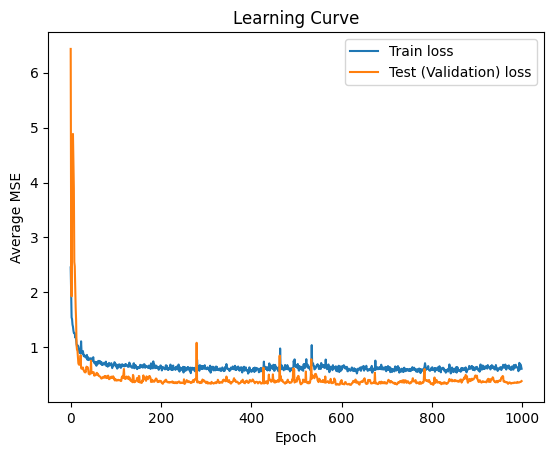

In [7]:
weightOperation = WeightOperation(model)

num_epochs = 1000 #Default value is 1000
best_test_acc, results = train(model=model,
      train_dataloader=train_loader,
      test_dataloader=test_loader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=num_epochs,
      device=device,
      writer=False,
      weight_op=weightOperation,
      classes_num = classes_num)


print("-" * 50 + "\n")


# Plot Train and Test Loss
plt.plot(results["train_loss"], label='Train loss')
plt.plot(results["test_loss"], label='Test (Validation) loss')
plt.title("Learning Curve")
plt.ylabel("Average MSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Confusion Matrix

Predicted Labels: [0 0 1 ... 0 0 0]
True Labels: [0 2 1 ... 0 0 0]
Accuracy: 0.9187
Precision (macro): 0.8379
Recall (macro): 0.5576
F1 Score (macro): 0.6179
Confusion Matrix:
[[777   2   0   2   0]
 [ 19 558   5   8   0]
 [ 13  16  12   2   0]
 [  6  38   2  29   0]
 [  6   3   0   0   2]]


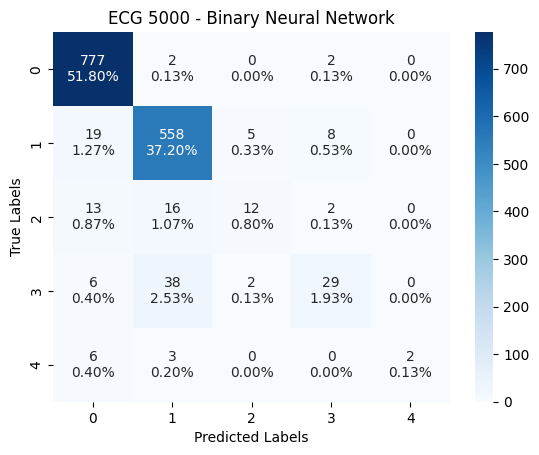

In [8]:
# Display confusion matrix (Built in version, not sure it works correctly)
#plot_cfm(model=model, test_loader=test_loader, classes=labels, mode="test", cnt=1, clt="ECG_5000", seed=seed, best_test_acc=best_test_acc, index=0)

# Set the model to evaluation mode
model.eval()

# Initialize a list to store predictions and true labels
predicted_labels = []
true_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for data, labels in test_loader:  # Replace `test_loader` with your validation loader if needed
        # Move data to the same device as the model
        data, labels = data.to(device), labels.to(device)
        
        # Perform a forward pass
        outputs = model(data)
        
        # Get the predicted class (index of the maximum logit)
        predictions = torch.argmax(outputs, dim=1)
        
        # Append predictions and true labels to the lists
        predicted_labels.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for further analysis
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# Print or return the predicted labels
print("Predicted Labels:", predicted_labels)
print("True Labels:", true_labels)



# Make predictions for validation set
val_y_predictions = predicted_labels
ECGdataset_val_y_flat = true_labels


# Calculate metrics
accuracy = accuracy_score(ECGdataset_val_y_flat, val_y_predictions)
precision = precision_score(ECGdataset_val_y_flat, val_y_predictions, average='macro', zero_division=1)
recall = recall_score(ECGdataset_val_y_flat, val_y_predictions, average='macro')
f1 = f1_score(ECGdataset_val_y_flat, val_y_predictions, average='macro')
conf_matrix = confusion_matrix(ECGdataset_val_y_flat, val_y_predictions)

#Print metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision (macro): {:.4f}".format(precision))
print("Recall (macro): {:.4f}".format(recall))
print("F1 Score (macro): {:.4f}".format(f1))
print("Confusion Matrix:")
print(conf_matrix)

model_performance = [accuracy, precision, recall, f1]
cf_matrix = np.array(conf_matrix)



plt.figure(dpi=100)

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2, in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
plt.title("ECG 5000 - Binary Neural Network")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()